### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 8
### Due: Saturday, Apr 6th at 11.59pm CT
---

## Only one problem this week

1. Use the following code snippet to read in SDSS galaxy color data.
<!--```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```-->

`data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

In [2]:
import numpy as np 
import scipy
from scipy.stats import uniform, norm, rv_histogram
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
from scipy import optimize
import chainconsumer
import corner
import dynesty
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from astroML.density_estimation import KNeighborsDensity
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn import preprocessing
from astroML.linear_model import (LinearRegression, PolynomialRegression,
                                  BasisFunctionRegression, NadarayaWatson)
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from astroML.linear_model import PolynomialRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from astroML.classification import GMMBayes




%matplotlib inline

/Users/levischult/miniconda3/envs/astr8070/lib/python3.10/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


# 1

In [3]:
! ls ../../../homeworks/hw_data/

hw3_data_1.npy hw4_data_2.npy hw6_data_1.npy hw8_data_1.npy
hw4_data_1.npy hw5_data_1.npy hw7_data_1.npy


In [4]:
data = np.load('../../../homeworks/hw_data/hw8_data_1.npy')
print(data.dtype)

[('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('specClass', '<U6'), ('redshift', '<f8'), ('redshift_err', '<f8')]


In [5]:
colnames = ['u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err']

In [6]:
# LSS making arrays
uming = data['u'] - data['g']
gminr = data['g'] - data['r']
rmini = data['r'] - data['i']
iminz = data['i'] - data['z']

zarr = data['redshift']
sclass = data['specClass']

In [7]:
print('num gal = ', np.sum(sclass=='GALAXY'))
print('num qso = ', np.sum(sclass=='QSO'))

num gal =  42808
num qso =  7192


# 2

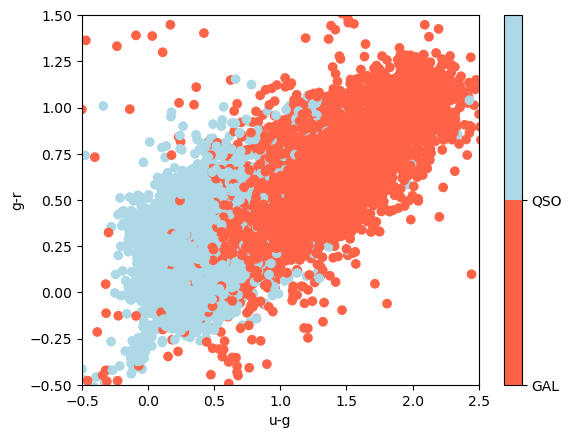

In [8]:
classlabels = [1 if s=='QSO' else 0 for s in sclass]

lab=['GAL', 'QSO']
colors=['tomato', 'lightblue']
plt.scatter(uming, gminr, c=classlabels, cmap=matplotlib.colors.ListedColormap(colors))
cb = plt.colorbar()
loc = np.arange(0,max(classlabels),max(classlabels)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(lab)
plt.xlabel('u-g')
plt.ylabel('g-r')
plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 1.5)
plt.show()

# 3

In [9]:
y = classlabels
X = np.vstack([uming, gminr, rmini, iminz, zarr]).T

X_train, X_test, y_train, y_test= train_test_split(X, y, train_size=0.8)

# 4

Best Curve is with 5 features


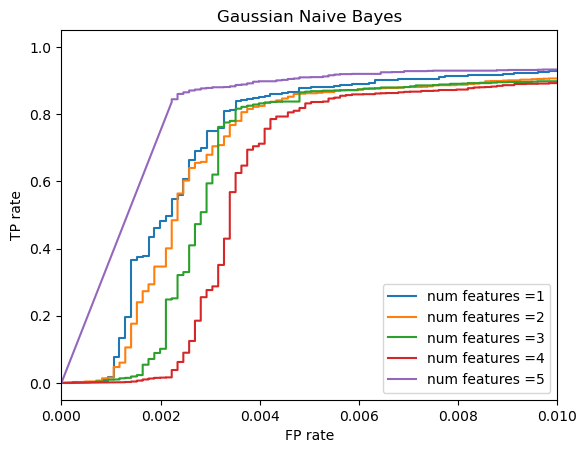

In [31]:
# LSS borrowed heavily from L19
introc = []
for i in range(5):
    gnb = GaussianNB()
    gnb.fit(X_train[:, 0:i+1], y_train)
    y_prob = gnb.predict_proba(X_test[:, 0:i+1])[:, 1]
    fpr, tpr, thresh = roc_curve(y_test, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])

    plt.plot(fpr, tpr, label=f'num features ={i+1}')
    
    # LSS integrating
    introc.append(np.trapz(tpr, fpr))


print(f'Best Curve is with {np.argmax(introc)+1} features')
plt.title('Gaussian Naive Bayes')
plt.xlim(0, 0.01)
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.legend()
plt.show()


* redshift seems to make the classification quite easy! Determined with integration
above

SRT: Good!

# 5

Best Curve is with 5 features


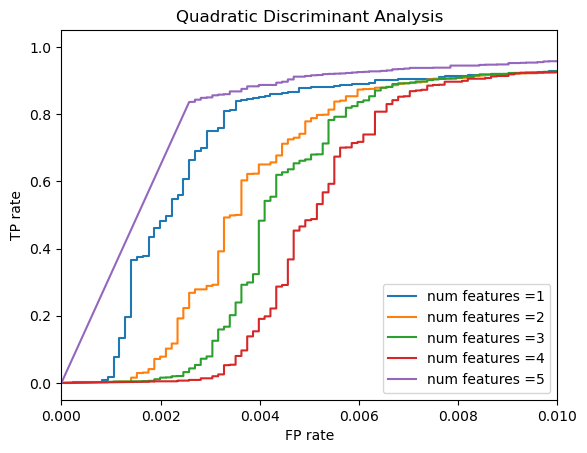

In [32]:
# LSS borrowed heavily from L19

introc = []
for i in range(5):
    model = QuadraticDiscriminantAnalysis()
    model.fit(X_train[:, 0:i+1], y_train)
    y_prob = model.predict_proba(X_test[:, 0:i+1])[:, 1]
    fpr, tpr, thresh = roc_curve(y_test, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])

    plt.plot(fpr, tpr, label=f'num features ={i+1}')

    # LSS integrating
    introc.append(np.trapz(tpr, fpr))


print(f'Best Curve is with {np.argmax(introc)+1} features')
plt.title('Quadratic Discriminant Analysis')
plt.xlim(0, 0.01)
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.legend()
plt.show()

# 6

Best Curve is with 9 components


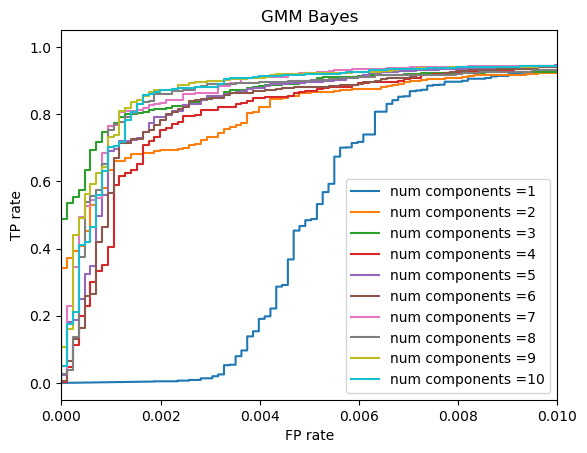

In [37]:
# LSS borrowed heavily from L19
# LSS making color only training/test datasets
X_trainoc = X_train[:, :4]
X_testoc = X_test[:, :4]


introc = []
for i in range(1, 11):
    model = GMMBayes(n_components=i)
    model.fit(X_trainoc, y_train)
    y_prob = model.predict_proba(X_testoc)[:, 1]
    fpr, tpr, thresh = roc_curve(y_test, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])

    plt.plot(fpr, tpr, label=f'num components ={i}')
    # LSS integrating
    introc.append(np.trapz(tpr, fpr))

gmmbestcomp = np.argmax(introc)+1
print(f'Best Curve is with {gmmbestcomp} components')

plt.title('GMM Bayes')
plt.xlim(0, 0.01)
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.legend()
plt.show()

SRT: Good effort. There is also an AUC (area under curve) function available within scikit learn.

# 7

Best Curve is with 85 components


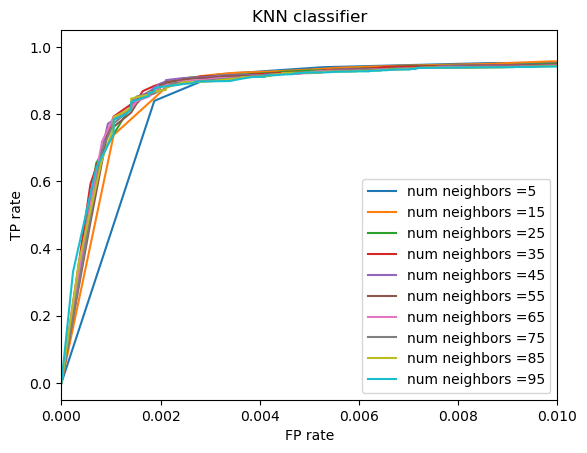

In [38]:
# LSS borrowed heavily from L19

introc = []
for i in np.arange(5, 100, 10):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_trainoc, y_train)
    y_prob = model.predict_proba(X_testoc)[:, 1]
    fpr, tpr, thresh = roc_curve(y_test, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])

    plt.plot(fpr, tpr, label=f'num neighbors ={i}')
    # LSS integrating
    introc.append(np.trapz(tpr, fpr))

knnbestcomp = np.arange(5, 100, 10)[np.argmax(introc)]
print(f'Best Curve is with {knnbestcomp} neighbors')

plt.title('KNN classifier')
plt.xlim(0, 0.01)
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.legend()
plt.show()

# 8

Best Curve is with 4 maxdepth


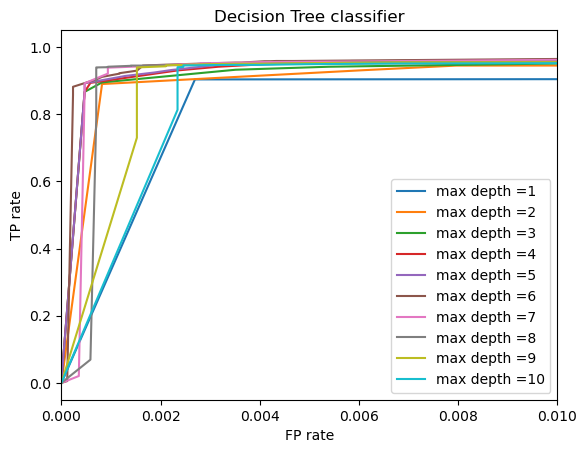

In [39]:
# LSS borrowed heavily from L19

introc=[]
for i in range(1, 11):
    model = DecisionTreeClassifier(max_depth=i)
    model.fit(X_train[:, :5], y_train)
    y_prob = model.predict_proba(X_test[:, :5])[:, 1]
    fpr, tpr, thresh = roc_curve(y_test, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])

    plt.plot(fpr, tpr, label=f'max depth ={i}')
    # LSS integrating
    introc.append(np.trapz(tpr, fpr))

dtbestcomp = np.argmax(introc)+1
print(f'Best Curve is with {dtbestcomp} maxdepth')

plt.title('Decision Tree classifier')
plt.xlim(0, 0.01)
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.legend()
plt.show()

SRT: Decision tree classification should only be on the 4 colors. This includes the redshift too. -2 points.

# 9

GaussianNB
QuadraticDiscriminantAnalysis
KNeighborsClassifier
DecisionTreeClassifier
GMMBayes
Best classifier is GMMBayes


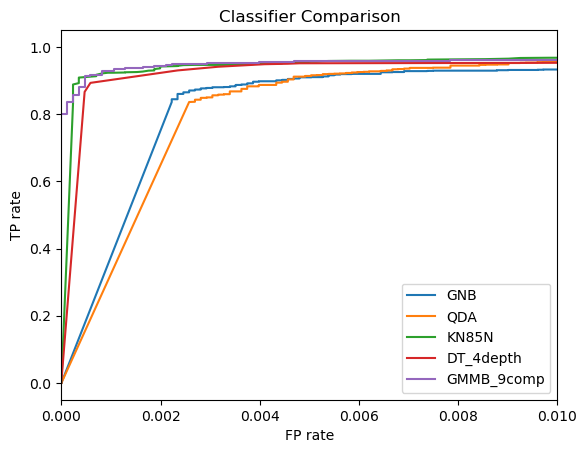

In [41]:
# LSS making color only training/test datasets
X_trainoc = X_train[:, :5]
X_testoc = X_test[:, :5]

# LSS from L19

# Fit all the models to the training data
def compute_models(*args):
    names = []
    probs = []
    for classifier, kwargs in args:
        print(classifier.__name__)
        clf = classifier(**kwargs)
        clf.fit(X_trainoc, y_train)
        
        #Note that we are outputing the probabilities [of class 1], not the classes
        y_probs = clf.predict_proba(X_testoc)[:, 1]

        names.append(classifier.__name__)
        probs.append(y_probs)

    return names, probs


names, probs = compute_models((GaussianNB, {}),
                              (QuadraticDiscriminantAnalysis, {}),
                              (KNeighborsClassifier,
                               dict(n_neighbors=knnbestcomp)),
                              (DecisionTreeClassifier,
                               dict(max_depth=dtbestcomp)),
                              (GMMBayes, dict(n_components=gmmbestcomp)))

labels = dict(GaussianNB='GNB',
              LinearDiscriminantAnalysis='LDA',
              QuadraticDiscriminantAnalysis='QDA',
              KNeighborsClassifier=f'KN{knnbestcomp}N',
              DecisionTreeClassifier=f'DT_{dtbestcomp}depth',
              GMMBayes=f'GMMB_{gmmbestcomp}comp',
              LogisticRegression='LR')

introc = []
for name, y_prob in zip(names, probs):
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    plt.plot(fpr, tpr, label=labels[name])
        # LSS integrating
    introc.append(np.trapz(tpr, fpr))

bestclf = np.argmax(introc)
print(f'Best classifier is {names[bestclf]}')

plt.title('Classifier Comparison')
plt.xlim(0, 0.01)
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.legend()
plt.show()



SRT: Taking the column index up to 5 includes the redshift (i.e., all 5 features). This indexing error has been carried through from earlier.

# 10

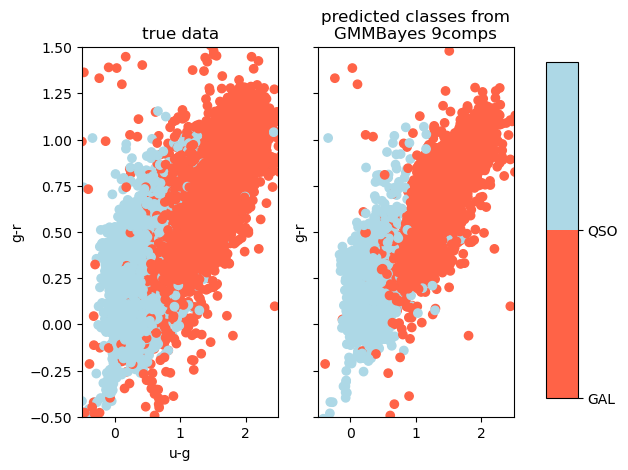

In [44]:
# LSS relevant stack overflows:
# https://stackoverflow.com/questions/13784201/how-to-have-one-colorbar-for-all-subplots
# https://stackoverflow.com/questions/12487060/color-according-to-class-labels 

clf = GMMBayes(n_components=gmmbestcomp)
clf.fit(X_trainoc, y_train)
ypred = clf.predict(X_testoc)

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
lab=['GAL', 'QSO']
colors=['tomato', 'lightblue']
im = axes[0].scatter(uming, gminr, c=y, cmap=matplotlib.colors.ListedColormap(colors))
im = axes[1].scatter(X_testoc[:, 0], X_testoc[:, 1], c=ypred, cmap=matplotlib.colors.ListedColormap(colors))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
loc = np.arange(0,max(classlabels),max(classlabels)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(lab)
axes[0].set_xlabel('u-g')
axes[0].set_title('true data')
axes[1].set_title(f'predicted classes from\nGMMBayes {gmmbestcomp}comps')
for i in range(2):
    axes[i].set_ylabel('g-r')
    axes[i].set_xlim(-0.5, 2.5)
    axes[i].set_ylim(-0.5, 1.5)
plt.show()

SRT: Very good. Of course the redshift helps alot. Even if you had done this only on the colors, it would still have good performance.